# **Homework 3 - WSD of WiC**
## Michela Proietti 1739846

First of all, we install missing libraries, we make all the needed imports and define all the paths to data and the tokenizer that will be used in different parts of the code.

In [1]:
! pip install transformers
! pip install pytorch-lightning
! pip install json-lines

     |████████████████████████████████| 2.6 MB 4.3 MB/s 
     |████████████████████████████████| 636 kB 46.0 MB/s 
     |████████████████████████████████| 895 kB 47.1 MB/s 
     |████████████████████████████████| 3.3 MB 27.1 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
     |████████████████████████████████| 916 kB 4.3 MB/s 
     |████████████████████████████████| 829 kB 21.3 MB/s 
     |████████████████████████████████| 272 kB 49.5 MB/s 
     |████████████████████████████████| 118 kB 48.0 MB/s 
     |████████████████████████████████| 1.3 MB 38.5 MB/s 
     |████████████████████████████████| 294 kB 50.5 MB/s 
     |████████████████████████████████| 142 kB 47.7 MB/s 
  Created wheel for future: filename=future-0.18.2-py3-none-any.whl size=491070 sha256=60a450bf3eb95e77fc29ba986cddf814e9e4ccec8a41964bfbde7a9a9d6e3f5b
  Stored in directory: /root/.cache/pip/wheels/56/b0/fe/4410d17

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import xml.etree.ElementTree as ET
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

import nltk
nltk.download('wordnet')
from nltk.corpus import wordnet as wn
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertModel, BertPreTrainedModel, BertConfig, AdamW
from torchmetrics.classification.accuracy import Accuracy

from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import seaborn as sns

import pytorch_lightning as pl
from collections import defaultdict
from typing import *
import torch.nn as nn
import torchmetrics
import collections
import torch
import json_lines
import tqdm
import csv
import os
import re

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [4]:
train_data_path = "/content/drive/MyDrive/NLP/Homework3/SemCor/semcor.data.xml"
val_data_path = "/content/drive/MyDrive/NLP/Homework3/Data_Validation/sample-dataset/semeval2015.data.xml"
test_data_path = "/content/drive/MyDrive/NLP/Homework3/Evaluation_Datasets/ALL/ALL.data.xml"

train_preprocessed = "/content/drive/MyDrive/NLP/Homework3/SemCor/semcor_gloss_example.csv"
val_preprocessed = "/content/drive/MyDrive/NLP/Homework3/Data_Validation/sample-dataset/semeval2015_gloss_example.csv"
test_preprocessed = "/content/drive/MyDrive/NLP/Homework3/Evaluation_Datasets/ALL/ALL_gloss_example.csv"

bert_inputs_train = "/content/drive/MyDrive/NLP/Homework3/train_dataset_gloss_example.csv"
bert_inputs_val = "/content/drive/MyDrive/NLP/Homework3/val_dataset_gloss_example.csv"
bert_inputs_test = "/content/drive/MyDrive/NLP/Homework3/test_dataset_gloss_example.csv"

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
tokenizer.add_special_tokens({'additional_special_tokens': ['[TGT]']})

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

1

The following function is used to retrieve the correct wordnet POS tags.

In [5]:
def get_wordnet_postag(pos):
    if pos == 'ADJ':
        return wn.ADJ
    elif pos.startswith('VERB'):
        return wn.VERB
    elif pos.startswith('NOUN'):
        return wn.NOUN
    elif pos.startswith('ADVERB'):
        return wn.ADV
    else:
        return ''

## **Preprocessing of the WSD data**
Here we preprocess the data that is needed to train and evaluate our WSD model. For each sentence that contains a word to be disambiguated, we retrieve all the relevant information, namely the lemma, the pos tag, the id of the instance to be disambiguated and the gold_key. Then, we find all senses that the considered word can have and for each of them we get the corresponding gloss. After all these steps, for each word to be disambiguated, so for each sentence, we will have as many samples as the number of senses that the word can have. So, we use a line that has as first element the number of samples we have for that instance, and all 'X' after that. These lines are used when we build the dataset in order to correctly structure the batches.

In [ ]:
# Function used to get the gold keys from the corresponding file
def get_gold_keys(path: str):
    gold_keys = []
    with open(path[:-len('.data.xml')] + '.gold.key.txt', "r", encoding="utf-8") as f:
          key = f.readline().strip().split()
          while key:
              gold_keys.append(key[1])
              key = f.readline().strip().split()
    return gold_keys

# Function that get all the relevant information from the file contaning data
def get_data(input_path: str):
    data = ET.ElementTree(file=input_path)
    root = data.getroot()

    sentences = []
    lemmas = []
    poss = []
    targets = []
    targets_start_idxs = []
    targets_end_idxs = []
    sense_keys = []
    instances = []

    for text in root:
        for s in text:
            sentence = []
            lemma = []
            pos = []
            target = []
            target_start_idx = []
            target_end_idx = []
            instance = []

            for token in s:
                assert token.tag == 'wf' or token.tag == 'instance'
                if token.tag == 'wf':
                    for i in token.text.split(' '):
                        sentence.append(i)
                        pos.append(get_wordnet_postag(token.attrib['pos']))
                        target.append('X')
                        lemma.append(token.attrib['lemma'])
                if token.tag == 'instance':
                    target_start = len(sentence)
                    for i in token.text.split(' '):
                        sentence.append(i)
                        pos.append(get_wordnet_postag(token.attrib['pos']))
                        target.append(token.attrib['id'])
                        lemma.append(token.attrib['lemma'])
                        instance.append(token.text)
                    target_end = len(sentence)
                    target_start_idx.append(target_start)
                    target_end_idx.append(target_end)

            sentences.append(sentence)
            lemmas.append(lemma)
            poss.append(pos)
            targets.append(target)
            targets_start_idxs.append(target_start_idx)
            targets_end_idxs.append(target_end_idx)
            instances.append(instance)

    return sentences, lemmas, poss, targets, targets_start_idxs, targets_end_idxs, instances

# Function that creates a csv file with the preprocessed data
def prepare_data(input_path: str, output_path: str):
    sentences, lemmas, poss, targets, targets_start_idxs, targets_end_idxs, instances = get_data(input_path)
    gold_keys = get_gold_keys(input_path)

    with open(output_path, "w", encoding="utf-8") as g:
        g.write('sentence\ttarget_id\ttarget_lemma\ttarget_pos\tsense_key\tinstance\tsynset\texamples\tlabel\n')
        num = 0
        for i in range(len(sentences)):
            for j in range(len(targets_start_idxs[i])):
                sentence = ' '.join(sentences[i])
                target_start = targets_start_idxs[i][j]
                target_end = targets_end_idxs[i][j]
                target_id = targets[i][target_start]
                target_lemma = lemmas[i][target_start]
                target_pos = poss[i][target_start]
                instance = instances[i][j]
                gold_key = gold_keys[num]
                num += 1

                # We add a target token right before and after the target word to be disambiguated
                sentence = sentence.replace(instance, '[TGT] ' + instance + ' [TGT]')
              
                # We retrieve all the senses that the target word can have
                senses = wn.lemmas(target_lemma, target_pos)
                g.write('\t'.join((str(len(senses)), 'X', 'X', 'X', 'X', 'X', 'X', 'X', 'X')))
                g.write('\n')

                # For each sense, we find the corresponding gloss and examples and we compute a label that is 1 if the sense key we are
                # considering is equal to the gold key and 0 otherwise. Then, we save all the information in the csv file.
                for sense in senses:
                  synset = sense.synset()
                  gloss = synset.definition()
                  examples = ' '.join(synset.examples())
                  if examples != '':
                    gloss = gloss + ' [SEP] ' + examples
                  label = int(sense.key() == gold_key)

                  g.write('\t'.join((sentence, target_id, target_lemma, target_pos, str(sense.key()), instance, str(synset), gloss, str(label))))
                  g.write('\n')

In [ ]:
# We preprocess the training, validation and test data getting three different CSV files
prepare_data(train_data_path, train_preprocessed)
prepare_data(val_data_path, val_preprocessed)
prepare_data(test_data_path, test_preprocessed)

## **Precomputing BERT inputs for the WSD data**
The training used to stop at 1% of the first epoch, because CUDA used to go out of memory. The most immediate way to solve this problem was to precompute the inputs to be given to BERT and store them, instead of computing them while creating the dataset.

As previously said, for each word in context we will have as many samples as the number of senses that it can have. Therefore, we will have mini-batches made up by all the samples referring to the same ambiguous word. For these mini-batches, just the label referring to the actual meaning of the word is 1, while all the others are 0. Our model will have to predict the index in the array of labels which refers to the correct meaning.



In [ ]:
# We load the preprocessed data we had previously stored in csv files
train_data = pd.read_csv(train_preprocessed,sep="\t",header=0).values
val_data = pd.read_csv(val_preprocessed,sep="\t",header=0).values
test_data = pd.read_csv(test_preprocessed,sep="\t",header=0).values

In [ ]:
# As we can see, for each target word to be disambiguated, we have as many samples as its possible senses.
# For example, the first word to be disambiguated is 'long', and it has 9 possible sense, so we have 9
# different samples that contain the same sentence, but different glosses/examples and labels.
for i in range(10):
  print(train_data[i])

['9' 'X' 'X' 'X' 'X' 'X' 'X' 'X' 'X']
['How [TGT] long [TGT] has it been since you reviewed the objectives of your benefit and service program ?'
 'd000.s000.t000' 'long' 'a' 'long%3:00:02::' 'long' "Synset('long.a.01')"
 'primarily temporal sense; being or indicating a relatively great or greater than average duration or passage of time or a duration as specified [SEP] a long life a long boring speech a long time a long friendship a long game long ago an hour long'
 '1']
['How [TGT] long [TGT] has it been since you reviewed the objectives of your benefit and service program ?'
 'd000.s000.t000' 'long' 'a' 'long%3:00:01::' 'long' "Synset('long.a.02')"
 'primarily spatial sense; of relatively great or greater than average spatial extension or extension as specified [SEP] a long road a long distance contained many long words ten miles long'
 '0']
['How [TGT] long [TGT] has it been since you reviewed the objectives of your benefit and service program ?'
 'd000.s000.t000' 'long' 'a' 'long%

In [ ]:
# This function uses BERT tokenizer to get the inputs for the BERT model and stores them in a csv file.
# We create minibatches of samples that contain the same word to be disambiguated
# but different glosses/examples and labels.
def save_bert_inputs(data: str, output_file: str, tokenizer: BertTokenizer, wic: bool = False):
  bert_inputs = []
  pairs = []
  
  for line in tqdm.tqdm(data):
      if (line[1] == 'X'):
          minibatch_len = int(line[0])
          if (pairs):
            bert_inputs.append(pairs)
            pairs = []
          continue
      elif (minibatch_len > 0):
          bert_input = tokenizer(line[0], line[7], return_token_type_ids = True, return_attention_mask = True)
          label = int(line[8])

          pairs.append([bert_input["input_ids"], bert_input["attention_mask"], bert_input["token_type_ids"], label])
  
  with open(output_file, 'w', encoding="utf-8", newline='') as f:
    writer = csv.writer(f)
    writer.writerow(['input_ids', 'attention_mask', 'token_type_ids', 'label'])
    writer.writerows(bert_inputs)

In [ ]:
save_bert_inputs(train_data, bert_inputs_train, tokenizer)
save_bert_inputs(val_data, bert_inputs_val, tokenizer)
save_bert_inputs(test_data, bert_inputs_test, tokenizer)

100%|██████████| 48542/48542 [00:59<00:00, 809.30it/s]


In [ ]:
# Here we simply show how the file is structured:
# each row contains all the samples belonging to the same mini-batch
# As we can see from the output, the first sample in the first mini-batch is the one
# referring to the actual meaning of the word, since it is the only one with label 1.

i = 0
with open(bert_inputs_val) as f:
    next(f)
    csv_reader = csv.reader(f, delimiter=',')
    for row in csv_reader:
      for sample in row:
        bert_inputs = sample.split('], ')

        input_ids = bert_inputs[0][2::].split(',')
        attention_mask = bert_inputs[1][1::].split(',')
        token_type_ids = bert_inputs[2][1::].split(',')
        label = int(bert_inputs[3][:1])

        input_ids = torch.tensor(list(map(int, input_ids)))
        attention_mask = torch.tensor(list(map(int, attention_mask)))
        token_type_ids = torch.tensor(list(map(int, token_type_ids)))
        label = torch.tensor(label, dtype=torch.long)

        print(input_ids)
        print(attention_mask)
        print(token_type_ids)
        print(label)
      print('######################################################')
      i += 1
      if (i == 2):
        break

tensor([  101,  2023, 30522,  6254, 30522,  2003,  1037, 12654,  1997,  1996,
         2647,  2270,  7667,  3189,  1006, 19044,  2099,  1007,  1012,   102,
         3015,  2008,  3640,  2592,  1006,  2926,  2592,  1997,  2019,  2880,
         3267,  1007,   102])
tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1])
tensor(1)
tensor([  101,  2023, 30522,  6254, 30522,  2003,  1037, 12654,  1997,  1996,
         2647,  2270,  7667,  3189,  1006, 19044,  2099,  1007,  1012,   102,
         2505,  3529,  2004,  1037,  6630,  1997,  1037,  2711,  1005,  1055,
         3241,  2011,  2965,  1997, 12613,  6017,   102])
tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 

# **Dataset definition**

In [6]:
# We zero-pad the sequences in the same sub_batch so that they have the same length
def collate_function(batch):

    collated_batch = []
    for sub_batch in batch:
        sub_collated = []
        input_ids = [sample[0] for sample in sub_batch]
        input_ids = torch.nn.utils.rnn.pad_sequence(input_ids, batch_first=True, padding_value=0)

        attention_mask = [sample[1] for sample in sub_batch]
        attention_mask = torch.nn.utils.rnn.pad_sequence(attention_mask, batch_first=True, padding_value=0)

        token_type_ids = [sample[2] for sample in sub_batch]
        token_type_ids = torch.nn.utils.rnn.pad_sequence(token_type_ids, batch_first=True, padding_value=0)

        labels = [sample[3] for sample in sub_batch]
        labels = torch.tensor(labels)

        collated_batch.append((input_ids, attention_mask, token_type_ids, labels))

    return collated_batch

In [7]:
class WSD_WiC_Dataset(Dataset):
  
  def __init__(self, data_path : str):
    self.data = []
    self.create_samples(data_path)

  # We retrieve BERT inputs from the previously created csv files and we organize
  # them in batches of elements, where each element is a mini-batch of samples as
  # described above.
  def create_samples(self, data_path):
    with open(data_path) as f:
      next(f)
      csv_reader = csv.reader(f, delimiter=',')
      for row in csv_reader:
        samples = []
        for sample in row:
          bert_inputs = sample.split('], ')

          input_ids = bert_inputs[0][2::].split(',')
          attention_mask = bert_inputs[1][1::].split(',')
          token_type_ids = bert_inputs[2][1::].split(',')
          label = int(bert_inputs[3][:1])

          input_ids = torch.tensor(list(map(int, input_ids)))
          attention_mask = torch.tensor(list(map(int, attention_mask)))
          token_type_ids = torch.tensor(list(map(int, token_type_ids)))
          label = torch.tensor(label, dtype=torch.long)
          
          samples.append((input_ids, attention_mask, token_type_ids, label))
    
        self.data.append(samples)

  def __len__(self):
    return len(self.data)

  def __getitem__(self, idx):
    return self.data[idx]

In [8]:
class WSDDataModule(pl.LightningDataModule):
    def __init__(self, data_train: str, data_val: str,
                data_test: str, batch_size: int, collate_fn=None) -> None:
      super().__init__()
      self.data_train = data_train
      self.data_val = data_val
      self.data_test = data_test
      self.batch_size = batch_size
      self.collate_fn = collate_fn
      self.train_dataset = None
      self.validation_dataset = None
      self.test_dataset = None

    def setup(self, stage: Optional[str] = None) -> None:
      if stage == 'fit':
        self.train_dataset = WSD_WiC_Dataset(self.data_train)
        self.validation_dataset = WSD_WiC_Dataset(self.data_val)
      elif stage == 'test':
        self.test_dataset = WSD_WiC_Dataset(self.data_test)
        
    def train_dataloader(self, *args, **kwargs) -> DataLoader:
      return DataLoader(self.train_dataset, batch_size=self.batch_size, collate_fn=self.collate_fn)

    def val_dataloader(self, *args, **kwargs) -> Union[DataLoader, List[DataLoader]]:
      return DataLoader(self.validation_dataset, batch_size=self.batch_size, collate_fn=self.collate_fn)

    def test_dataloader(self, *args, **kwargs) -> Union[DataLoader, List[DataLoader]]:
      return DataLoader(self.test_dataset, batch_size=self.batch_size, collate_fn=self.collate_fn)

In [9]:
WSD_dm = WSDDataModule(data_train=bert_inputs_train,
                      data_val=bert_inputs_val,
                      data_test=bert_inputs_test,
                      batch_size=4,
                      collate_fn=collate_function)

In [ ]:
# We show how the batches are organized:
# each batch is made up by sub_batches of variable length, and the length depends
# on how many senses the target word we are considering has. In this case, the sub_batch
# has 4 elements, which means there are 4 different sense keys that refer to the same
# word, among which the first one corresponds to the gold key, since the tensor containing
# the labels has 1 as first element.
WSD_dm.setup('test')
test_dataloader = WSD_dm.test_dataloader()
for batch in test_dataloader:
  print(f"Batch length = : {len(batch)}")
  for sub_batch in batch:
    print(f"Sub-batch length = : {len(sub_batch)}")
    print(sub_batch)
    break
  break

Batch length = : 4
Sub-batch length = : 4
(tensor([[  101,  1996, 30522,  2396, 30522,  1997,  2689,  1011, 13060,  2003,
         14099,  2000,  1996,  2394,  1010,  1998,  1010,  2066,  2087,  2394,
         14099,  6447,  1010,  4895, 18447, 13348, 18507,  2000,  1996,  2717,
          1997,  1996,  2088,  1012,   102,  1996,  3688,  1997,  2529, 14842,
          1025,  2573,  1997,  2396, 13643,   102,  2019,  2396,  4538,  1037,
          2986,  3074,  1997,  2396,   102,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0],
        [  101,  1996, 30522,  2396, 30522,  1997,  2689,  1011, 13060,  2003,
         14099,  2000,  1996,  2394,  1010,  1998,  1010,  2066,  2087,  2394,
         14099,  6447,  1010,  4895, 18447, 13348, 18507,  2000,  1996,  2717,
          1997,  1996,  2088,  1012,   102,  1996,  4325,  1997,  3376,  2030,
          3278,  2477,   102,  2396,  2515,  2025,  2342,  2000,

## **Model definition**

In [22]:
class MyBERTModel(BertPreTrainedModel):
  def __init__(self, config):
    super().__init__(config)

    # BERT pretrained embeddings
    self.bert = BertModel(config)

    # Dropout and linear layer to perform the classification
    self.bert_dropout = torch.nn.Dropout(config.hidden_dropout_prob)

    self.lin1 = torch.nn.Linear(config.hidden_size, 256)
    self.lin2 = torch.nn.Linear(256, 128)
    self.lin3 = torch.nn.Linear(128, 1)

    self.dropout = torch.nn.Dropout(0.4)

    self.init_weights()
  
  def forward(self, input_ids: torch.Tensor, attention_mask: torch.Tensor, token_type_ids:torch.Tensor):
    out = self.bert(input_ids, attention_mask, token_type_ids)
    out = self.bert_dropout(out[1])
    out = self.lin1(out)
    out = self.dropout(out)
    out = self.lin2(out)
    out = self.dropout(out)
    logits = self.lin3(out).squeeze(-1)

    return logits

class WSDClassifier(pl.LightningModule):
    def __init__(self, config, tokenizer):
      super().__init__()

      self.bert = MyBERTModel.from_pretrained('bert-base-uncased', config=config)
      self.bert.resize_token_embeddings(len(tokenizer)) # Needed to account for the additional target token

      # Defining loss function and metrics
      self.loss_fn = torch.nn.CrossEntropyLoss()
      self.val_acc = Accuracy()
      self.test_acc = Accuracy()

      self.save_hyperparameters()

    def forward(self, input_ids: torch.Tensor, attention_mask: torch.Tensor, token_type_ids:torch.Tensor, y: Optional[torch.Tensor] = None) -> Dict[str, torch.Tensor]:
      logits = self.bert(input_ids, attention_mask, token_type_ids)
      result = {'logits': logits}

      # We compute the loss and the index in the array of labels corresponding to 
      # the sense key that is equal to the gold key
      if y is not None:
        labels = torch.max(y, -1).indices.detach()
        result['labels'] = labels.item()

        loss = self.loss_fn(logits.unsqueeze(dim=0), labels.unsqueeze(dim=-1))
        result['loss'] = loss
        
      return result

    def training_step(self, batch: Tuple[torch.Tensor], batch_idx: int) -> torch.Tensor:
      batch_loss = 0
      for minibatch in batch:
          output = self.forward(minibatch[0], minibatch[1], minibatch[2], minibatch[3])
          batch_loss += output['loss']

      self.log('train_loss', batch_loss/len(batch), prog_bar=True)
      return batch_loss / len(batch)

    def validation_step(self, batch: Tuple[torch.Tensor], batch_idx: int):
      batch_loss = 0
      predictions = []
      labels = []

      for minibatch in batch:
          output = self.forward(minibatch[0], minibatch[1], minibatch[2], minibatch[3])
          predictions.append(torch.argmax(output['logits'], dim=-1).item())
          labels.append(output['labels'])
          batch_loss += output['loss']

      loss = batch_loss / len(batch)
      self.log('val_loss', loss, prog_bar=True)
      
      return {"loss": loss, "predictions": predictions, "labels": labels}

    # Function needed since each batch is organized in sub-batches
    def validation_epoch_end(self, val_step_outputs):
      predictions = []
      labels = []
      for val_step_output in val_step_outputs:
        predictions.extend(val_step_output['predictions'])
        labels.extend(val_step_output['labels'])

      self.val_acc(torch.tensor(predictions), torch.tensor(labels))
      self.log('val_acc', self.val_acc, prog_bar=True)

    def test_step(self, batch: Tuple[torch.Tensor], batch_idx: int):
      batch_loss = 0
      predictions = []
      labels = []
      for minibatch in batch:
          output = self.forward(minibatch[0], minibatch[1], minibatch[2], minibatch[3])
          predictions.append(torch.argmax(output['logits'], dim=-1).item())
          labels.append(output['labels'])
          batch_loss += output['loss']

      loss = batch_loss / len(batch)
      self.log('test_loss', loss, prog_bar=True)
      
      return {"loss": loss, "predictions": predictions, "labels": labels}

    # Function needed since each batch is organized in sub-batches
    def test_epoch_end(self, test_step_outputs):
      predictions = []
      labels = []
      for test_step_output in test_step_outputs:
        predictions.extend(test_step_output['predictions'])
        labels.extend(test_step_output['labels'])

      self.test_acc(torch.tensor(predictions), torch.tensor(labels))
      self.log('test_acc', self.test_acc, prog_bar=True)

    # Function that outputs the predictions for the WSD task
    def get_predictions(self, sentence: str, instance:str, pos: str, lemma: str, verbose=False):
      # We add the target token to the sentence
      sentence = sentence.replace(instance, '[TGT] ' + instance + ' [TGT]')

      # We retrieve all possible senses for the target word
      if (lemma is None):
        senses = wn.lemmas(instance, pos)
      else:
        senses = wn.lemmas(lemma, pos)

      keys = []
      glosses = []

      # For each sense we retrieve the corresponding sense key and gloss/examples
      for sense in senses:
        synset = sense.synset()
        gloss = synset.definition()
        examples = ' '.join(synset.examples())
        if examples != '':
          gloss = gloss + ' [SEP] ' + examples
        keys.append(sense.key())
        glosses.append(gloss)

      # For each gloss, we get the BERT inputs, and append them to the samples array
      samples = []
      for gloss in glosses:

        bert_inputs = tokenizer(sentence, gloss, return_token_type_ids = True, return_attention_mask = True)

        samples.append((torch.tensor(bert_inputs["input_ids"]), torch.tensor(bert_inputs["attention_mask"]), torch.tensor(bert_inputs["token_type_ids"]), None))

      # We need torch.no_grad, because we don't want to change the weights of our model
      # but just to get the output it gives
      with torch.no_grad():
        # initialize the logits
        logits = torch.zeros(len(glosses), dtype=torch.double).to(device)
        
        # For each sample, we get the logits given as output by the model
        for i, sample in list(enumerate(samples)):
          input_ids = sample[0].unsqueeze(0).to(device)
          attention_mask = sample[1].unsqueeze(0).to(device)
          token_type_ids = sample[2].unsqueeze(0).to(device)

          logits[i] = self.forward(input_ids, attention_mask, token_type_ids, None)['logits']

        # We get the scores by applying the softmax function on the logits
        scores = torch.softmax(logits, dim=0)

      # We sort the predictions so that the first one is the most probable one
      predictions = sorted(zip(keys, glosses, scores), key=lambda x: x[-1], reverse=True)

      # We get the most probable sense key
      try:
        wsd_prediction = predictions[0][0]
      except:
        if lemma is not None:
          return self.get_predictions(sentence.replace(instance, lemma), lemma, pos, None, False)
        else:
          return 'None'

      # We plot the various senses and the corresponding scores
      if verbose:
        if predictions is not None:
          print("OUTPUT PREDICTIONS:\n")
          for i, (key, gloss, score) in enumerate(predictions):
            print(f"Sense key: {key}, Gloss + Examples: {gloss}\n            => Score = {score}\n")
      
      return wsd_prediction

    def predict(self, input_pairs):
      wsd_predictions = []

      for pair in input_pairs:
        sentence1 = pair['sentence1']
        sentence2 = pair['sentence2']

        instance1 = sentence1[int(pair['start1']):int(pair['end1'])]
        instance2 = sentence2[int(pair['start2']):int(pair['end2'])]

        lemma = pair['lemma']
        pos = pair['pos']

        # We get the most probable sense for each of the two words in the two different contexts
        wsd_sentence1 = self.get_predictions(sentence1.lower(), instance1.lower(), get_wordnet_postag(pos), lemma, False)
        wsd_sentence2 = self.get_predictions(sentence2.lower(), instance2.lower(), get_wordnet_postag(pos), lemma, False)
        
        wsd_predictions.append((wsd_sentence1, wsd_sentence2))
      
      # We check whether the two wsd predictions are the same, meaning that the two words are used with the
      # same meaning in the two different contexts.
      wic_predictions = ['True' if prediction[0]==prediction[1] else 'False' for prediction in wsd_predictions]
              
      return wic_predictions, wsd_predictions

    def loss(self, pred, y):
      return self.loss_fn(pred, y)

    def configure_optimizers(self):
      params = list(self.bert.named_parameters())
      no_decay = ["bias", "gamma", "beta"]
      optimizer_grouped_parameters = [
            {
                "params": [p for n, p in params if not any(nd in n for nd in no_decay)],
                "weight_decay_rate": 0.01
            },
            {
                "params": [p for n, p in params if any(nd in n for nd in no_decay)],
                "weight_decay_rate": 0.0
            }]

      optimizer = AdamW(optimizer_grouped_parameters, lr=2e-5, eps=1e-8)
      return optimizer

In [23]:
config = BertConfig.from_pretrained('bert-base-uncased', num_labels=2, hidden_dropout_prob=0.1, hidden_size=768)
model = WSDClassifier(config, tokenizer).to(device)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing MyBERTModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing MyBERTModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing MyBERTModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of MyBERTModel were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['lin3.weight', 'lin1.bias

In [20]:
def get_trainer() -> pl.Trainer:
    # If the validation accuracy does not increase for 3 epochs we perform early stopping and the training ends
    early_stopping = pl.callbacks.EarlyStopping(
    monitor='val_acc',
    patience=2,
    verbose=True,
    mode='max')

    # We define the trainer, setting the maximum number of epochs to 10
    trainer = pl.Trainer(max_epochs=4, gpus=1, progress_bar_refresh_rate=50, callbacks=[early_stopping]) # BERT paper suggets max_epochs = 2, 3, 4
    
    return trainer

### **Training**

In [17]:
# We define the trainer and train our model
trainer = get_trainer()
trainer.fit(model=model, datamodule=WSD_dm)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/core/datamodule.py:424: LightningDeprecationWarning: DataModule.prepare_data has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.prepare_data.
  f"DataModule.{name} has already been called, so it will not be called again. "
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/core/datamodule.py:424: LightningDeprecationWarning: DataModule.setup has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.setup.
  f"DataModule.{name} has already been called, so it will not be called again. "
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type             | Params
----------------------------------------------
0 | bert     | MyBERTModel      | 109 M 
1 | loss_fn  | CrossEntropyLoss | 0     


Validation sanity check: 0it [00:00, ?it/s]

Training: -1it [00:00, ?it/s]

RuntimeError: ignored

In [18]:
# We save the model
torch.save(model.state_dict(), "/content/drive/MyDrive/NLP/Homework3/Results/trained_model_gloss_examples_256-128-d4.pth")

### **Evaluation on the test set**

In [14]:
model.load_state_dict(torch.load("/content/drive/MyDrive/NLP/Homework3/Results/trained_model_gloss_examples_256-128-d4.pth"))
model.eval()

trainer = get_trainer()
trainer.test(model=model, datamodule=WSD_dm)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/core/datamodule.py:424: LightningDeprecationWarning: DataModule.prepare_data has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.prepare_data.
  f"DataModule.{name} has already been called, so it will not be called again. "
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/core/datamodule.py:424: LightningDeprecationWarning: DataModule.setup has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.setup.
  f"DataModule.{name} has already been called, so it will not be called again. "
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_acc': 0.7131479978561401, 'test_loss': 0.9504134058952332}
--------------------------------------------------------------------------------


/usr/local/lib/python3.7/dist-packages/pytorch_lightning/core/datamodule.py:424: LightningDeprecationWarning: DataModule.teardown has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.teardown.
  f"DataModule.{name} has already been called, so it will not be called again. "


[{'test_acc': 0.7131479978561401, 'test_loss': 0.9504134058952332}]

In [ ]:
sentence =  'How long has it been since you reviewed the objectives of your benefit and service program ?'

prediction = model.get_predictions(sentence, 'long', get_wordnet_postag('ADJ'), None, verbose=True)
print(f"The most probable sense key is: {prediction}")

OUTPUT PREDICTIONS:

Sense key: long%3:00:02::, Gloss + Examples: primarily temporal sense; being or indicating a relatively great or greater than average duration or passage of time or a duration as specified [SEP] a long life a long boring speech a long time a long friendship a long game long ago an hour long
            => Score = 0.9634765684486432

Sense key: long%5:00:00:provident:00, Gloss + Examples: planning prudently for the future [SEP] large goals that required farsighted policies took a long view of the geopolitical issues
            => Score = 0.028436554624019013

Sense key: long%3:00:01::, Gloss + Examples: primarily spatial sense; of relatively great or greater than average spatial extension or extension as specified [SEP] a long road a long distance contained many long words ten miles long
            => Score = 0.005806163313303585

Sense key: long%5:00:00:abundant:00, Gloss + Examples: having or being more than normal or necessary:"long on brains" [SEP] in long sup

## **Preprocessing of WiC data**

In [13]:
path_to_val_data = '/content/drive/MyDrive/NLP/Homework3/WiC/dev.jsonl'
path_to_val_keys = '/content/drive/MyDrive/NLP/Homework3/WiC/dev_wsd.txt'
bert_inputs_wic = '/content/drive/MyDrive/NLP/Homework3/WiC/bert_inputs_gloss_examples.csv'

In [14]:
# We get the gold keys that represent the labels for the WSD task
def get_wsd_labels(path: str):
  labels = []
  with open(path, 'r') as f:
    lines = f.readlines()
    for line in lines:
      id, gold_key = line.split()
      labels.append(gold_key)
  return labels

# We get the labels for the WiC task
def get_wic_labels(path:str):
  labels = []
  with open(path) as f:
    for line in json_lines.reader(f):
      labels.append(line['label'])
  return labels

In [ ]:
# Returns the gold keys for the WiC data
def get_wic_keys(path: str):
  gold_keys = dict()
  with open(path, 'r') as f:
    lines = f.readlines()
    for line in lines:
      id, gold_key = line.split()
      gold_keys[id] = gold_key
  return gold_keys

# We preprocess both sentences in the WiC dataset, we get the glosses for each possible sense
# of the word to disambiguate and we tokenize the concatenation of the sentence and the glosses
# to precompute the inputs for the BERT model and store them in a csv file
def preprocess_wic_data(data_path:str, keys_path:str, output_file: str, tokenizer: BertTokenizer):
  sentences = []
  poss = []
  lemmas = []
  ids = []
  instances = []
  keys = []
  bert_inputs = []

  gold_keys = get_wic_keys(keys_path)

  with open(data_path) as f:
    for line in json_lines.reader(f):
      sentence1 = line['sentence1']
      sentence2 = line['sentence2']

      id = line['id']
      id1 = id + '.s1'
      id2 = id + '.s2'

      pos = get_wordnet_postag(line['pos'])
      lemma = line['lemma']

      instance1 = sentence1[int(line['start1']):int(line['end1'])]
      instance2 = sentence2[int(line['start2']):int(line['end2'])]

      # Add the target token right before and after the word to disambiguate
      sentence1 = sentence1.replace(instance1, '[TGT] ' + instance1 + ' [TGT]')
      sentence2 = sentence2.replace(instance2, '[TGT] ' + instance2 + ' [TGT]')

      # Get all possible senses
      senses = wn.lemmas(lemma, pos)

      samples1 = []
      samples2 = []

      # For each sense, we retrieve the gloss and build the BERT inputs
      for sense in senses:
        synset = sense.synset()
        gloss = synset.definition()
        examples = ' '.join(synset.examples())
        if examples != '':
          gloss = gloss + ' [SEP] ' + examples
        label1 = int(sense.key() == gold_keys[id1])
        label2 = int(sense.key() == gold_keys[id2])
      
        bert_input1 = tokenizer(sentence1, gloss, return_token_type_ids = True, return_attention_mask = True)
        bert_input2 = tokenizer(sentence2, gloss, return_token_type_ids = True, return_attention_mask = True)

        samples1.append((bert_input1["input_ids"], bert_input1["attention_mask"], bert_input1["token_type_ids"], label1))
        samples2.append((bert_input2["input_ids"], bert_input2["attention_mask"], bert_input2["token_type_ids"], label2))

      if (samples1 and samples2):
        bert_inputs.append(samples1)
        bert_inputs.append(samples2)
  
  with open(output_file, 'w', encoding="utf-8", newline='') as f:
    writer = csv.writer(f)
    writer.writerow(['input_ids', 'attention_mask', 'token_type_ids', 'label'])
    writer.writerows(bert_inputs)

In [ ]:
# We precompute the BERT inputs and store them in a csv file
preprocess_wic_data(path_to_val_data, path_to_val_keys, bert_inputs_wic, tokenizer)

In [ ]:
# We show two sub_batches, that as we can see are made up by a different number of samples
i = 0
with open(bert_inputs_wic) as f:
    next(f)
    csv_reader = csv.reader(f, delimiter=',')
    for row in csv_reader:
      for sample in row:
        bert_inputs = sample.split('], ')

        input_ids = bert_inputs[0][2::].split(',')
        attention_mask = bert_inputs[1][1::].split(',')
        token_type_ids = bert_inputs[2][1::].split(',')
        label = int(bert_inputs[3][:1])

        input_ids = torch.tensor(list(map(int, input_ids)))
        attention_mask = torch.tensor(list(map(int, attention_mask)))
        token_type_ids = torch.tensor(list(map(int, token_type_ids)))
        label = torch.tensor(label, dtype=torch.long)

        print(input_ids)
        print(attention_mask)
        print(token_type_ids)
        print(label)
      print('######################################################')
      i += 1
      if (i == 2):
        break

tensor([  101,  2053, 11075,  1999,  1037,  3206,  4618,  2022, 10009,  2004,
         9345,  4667,  1996,  5368,  1997, 30522, 22983, 30522,  2104,  2248,
         2375,  1012,   102,  2028,  1997,  3618,  4635,  2030,  2276,  2030,
         3737,   102])
tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
        1, 1, 1, 1, 1, 1, 1, 1])
tensor(1)
tensor([  101,  2053, 11075,  1999,  1037,  3206,  4618,  2022, 10009,  2004,
         9345,  4667,  1996,  5368,  1997, 30522, 22983, 30522,  2104,  2248,
         2375,  1012,   102,  1996,  2132,  1997,  1037,  3412,  2451,   102])
tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
        1, 1, 1, 1, 1, 1])
tensor(0)
tensor([  101,  2053, 11075,  1999,  1037,  3206

### **DataModule definition**

In [15]:
class WiCDataModule(pl.LightningDataModule):

  def __init__(self,
               test_data_path: str,
               batch_size: int,
               collate_fn=None):
    
    super().__init__()
    
    # with test set and dataloader only
    self.test_data_path = test_data_path
    self.collate_fn = collate_fn
    self.batch_size = batch_size

    self.test_dataset = None
  
  def setup(self, stage: Optional[str] = None) -> None:
    if stage == 'test':
      self.test_dataset = WSD_WiC_Dataset(self.test_data_path)

  def test_dataloader(self, *args, **kwargs) -> Union[DataLoader, List[DataLoader]]:
    return DataLoader(self.test_dataset, batch_size=self.batch_size, collate_fn=self.collate_fn)

In [16]:
WiC_dm = WiCDataModule(bert_inputs_wic,
                       batch_size=4,
                       collate_fn=collate_function)

In [ ]:
WiC_dm.setup('test')
test_dataloader = WiC_dm.test_dataloader()
for batch in test_dataloader:
  print(f"Batch length = : {len(batch)}")
  for sub_batch in batch:
    print(f"Sub-batch length = : {len(sub_batch)}")
    print(sub_batch)
    break
  break

Batch length = : 4
Sub-batch length = : 4
(tensor([[  101,  2053, 11075,  1999,  1037,  3206,  4618,  2022, 10009,  2004,
          9345,  4667,  1996,  5368,  1997, 30522, 22983, 30522,  2104,  2248,
          2375,  1012,   102,  2028,  1997,  3618,  4635,  2030,  2276,  2030,
          3737,   102,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0],
        [  101,  2053, 11075,  1999,  1037,  3206,  4618,  2022, 10009,  2004,
          9345,  4667,  1996,  5368,  1997, 30522, 22983, 30522,  2104,  2248,
          2375,  1012,   102,  1996,  2132,  1997,  1037,  3412,  2451,   102,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0],
        [  101,  2053, 11075,  1999,  1037,  3206,  4618,  2022, 10009,  2004,
          9345,  4667,  1996,  5368,  1997, 30522, 22983, 30522,  2104,  2248,
          2375,  1012,   102,  1037,  4337,  4630,  2040,  2003,  2583,  2000,
          4154,  9169,   102,     0,    

### **Model evaluation on the WiC data for the WSD task**

In [20]:
model.load_state_dict(torch.load("/content/drive/MyDrive/NLP/Homework3/Results/trained_model_gloss_examples_256-128-d4.pth"))
model.eval()

trainer = get_trainer()
trainer.test(model=model, datamodule=WiC_dm)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_acc': 0.6782901883125305, 'test_loss': 0.9232341051101685}
--------------------------------------------------------------------------------


[{'test_acc': 0.6782901883125305, 'test_loss': 0.9232341051101685}]

### **Model evaluation on the WiC task**

In [24]:
# since we do not have the pl.Trainer that sets eval() for us, we have to do it manually
model.load_state_dict(torch.load("/content/drive/MyDrive/NLP/Homework3/Results/trained_model_gloss_examples_256-128-d4.pth"))
model.eval()
model.to(device)

wic_predictions = []
wsd_predictions = []

wic_data = []
with open(path_to_val_data) as f:
    for line in json_lines.reader(f):
      wic_data.append(line)

for batch_start in range(0, len(wic_data), 4):
  wic_prediction, wsd_prediction = model.predict(wic_data[batch_start : batch_start+4])

  wic_predictions += wic_prediction
  wsd_predictions.extend([elem for prediction in wsd_prediction for elem in prediction])

In [25]:
wsd_labels = get_wsd_labels(path_to_val_keys)
wic_labels = get_wic_labels(path_to_val_data)

wsd_acc = accuracy_score(wsd_labels, wsd_predictions)
print(f'WSD - Accuracy score = {wsd_acc:.4f}')

wic_acc = accuracy_score(wic_labels, wic_predictions)
print(f'WiC - Accuracy score = {wic_acc:.4f}')

WSD - Accuracy score = 0.6709
WiC - Accuracy score = 0.7869


In [26]:
labels = [1 if label == 'True' else 0 for label in wic_labels]
predictions = [1 if pred == 'True' else 0 for pred in wic_predictions]

print('WiC - CLASSIFICATION REPORT\n')
print(classification_report(labels, predictions, labels=[1, 0], digits=4))

WiC - CLASSIFICATION REPORT

              precision    recall  f1-score   support

           1     0.8263    0.7800    0.8025       500
           0     0.7436    0.7955    0.7687       401

    accuracy                         0.7869       901
   macro avg     0.7849    0.7878    0.7856       901
weighted avg     0.7895    0.7869    0.7874       901



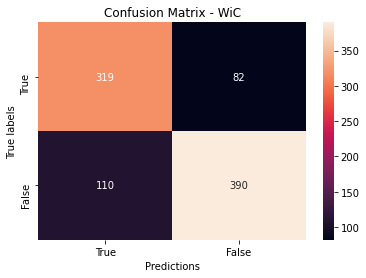

In [27]:
data = {'True labels': labels, 'Predicted': predictions}
df = pd.DataFrame(data, columns=['True labels','Predicted'])
confusion_matrix = pd.crosstab(df['True labels'], df['Predicted'], rownames=['Actual'], colnames=['Predicted'])
ax = plt.subplot()
sns.heatmap(confusion_matrix, ax=ax, annot=True, fmt='d')

ax.set_title('Confusion Matrix - WiC')
ax.set_xlabel('Predictions')
ax.set_ylabel('True labels')
ax.xaxis.set_ticklabels(['True', 'False'])
ax.yaxis.set_ticklabels(['True', 'False'])

print()